# Naive Bayes

## 1. Classifying Digits
In this part we will test digits classification on the MNIST dataset, using Bernoulli Naive Bayes (a generative model), in contrast to the Multivariate Decision Tree (a discriminative model) we used before.

The MNIST dataset contains 28x28 grayscale images of handwritten digits between 0 and 9 (10 classes). For mathmatical analysis clarity, and for matching expected API, flatten each image to create a 1D array with 784 elements.

### Loading the MNIST dataset
Load the MNIST data set. The digits dataset is one of datasets scikit-learn comes with that do not require the downloading of any file from some external website. 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


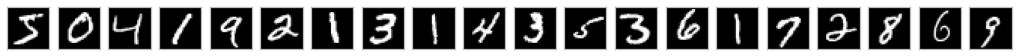

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from keras.datasets import mnist
import seaborn as sns

sns.set()
plt.style.use('bmh')

# let's run this on the full dataset:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# let's see a small sample of the data

fig=plt.figure(figsize=(18,12))
for i in range(20):
    fig.add_subplot(1,20, i+1, xticks=[], yticks=[])
    plt.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))
plt.show()


x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)

### Bernoulli Naive Bayes
If we know how the digits are generated, then we know how to classify them (simply choose the digit class which will maximize the posterior probability) --- but which model should we use for describing the digits generation?

In this part we will try a very simplified model of digits creation (which is obviously not the same as the "real" model), using a Naive Bayes over an underlying Bernoulli distribution --- that is, we will assume that given a digit class, the pixels of the images are the result of independent coin flips, each with its own "head" probability.

Note that since we assume each pixl is either 0 (black) or 1 (white), we will need to adjust (preprocess) our data accrodingly (see below).

So, the model is stated as follows:
$$
\begin{align}
\text{Domain} && x \in \{0,1\}^{784} \\
\text{Prior} && \pi_j = \Pr(y=j) \\
\text{Likelihood} && P_j(x) = \Pr(x | y=j) \\
\end{align}
$$

Where for each $i\in 0\ldots 784$ it holds that
$$
P_{ji}(x_i) = \Pr(x_i | y=j) =
\begin{cases}
p_{ji} & \text{if } x_i=1 \\
1-p_{ji} & \text{if } x_i=0 \\
\end{cases}
$$


#### Question 1
Write the classification rule based on this Naive Bayes model. 
How would you esitmate each of the parameters of the model based on the trainning data? 


**Bonus:** Think of edge cases which may effect your estimator in an undesired way.

#### Answer 1

The classification rule is predict the class $ c_i $ that maximizes the estimation of $ p(c_i|x_i)$ when $ x_i $ is the i-th sample from the test. 
$ p(c_i|x_i) $ is proportional to the prior probability of a class C times the likelihood to get 1 or 0 for a specifc feature given the class c => $ p(c)*p(x_i|c)$ . p(c) is estimaded by the ratio - number of instances of class c / num of samples, $ p(x_i =1|c) $ is estimated by the ratio - num of times x_i was 1 in samples from class c / num of samples in class c. $ p(x_i =0|c)$ is of course the complement of this value i.e $ 1-p(x_i =1|c)$ .



The classification rule based on this NB model is maximizing the posterior probability, which is  $ p(y| x) $:
(let's mark class c as y:)

$ P ( y| x) \propto P(y) * P(x | y) = P(y) \prod\limits _{i=1} ^{n}{P(x_i}|y) $ 

To make a classification, we want to find the class that maximized  $ P ( y| x)  $:

$y =  \underset{y}argmax{ P(y) P(x | y) }$ 

$y =  \underset{y}argmaxP(y) \prod\limits _{i=1} ^{n}{P(x_i}|y)$ 

which is equivalent to maximizing log likelihood (to avoid underflow): 

$y =  \underset{y}argmax\log{P(y)} + \sum\limits _{i=1} ^{n} \log({P(x_i}| y)$ 

$y =  \underset{y}argmax\log{P(y)} + \sum\limits _{i=1} ^{n} \log({p_{yi}^{x_{i}}(1-p_{yi})^{(1-x_i)}})$ 

  

***
Estimating these based on training data:

- __Priors P(y)__  are calculated as the count of each label divided by the total number of labels - 
- __Likelihood P(X|y)__ is calculated by multiplying the individual features conditional probability, meaning: p(X0|y) * P(X1|y)....
- __Individual feature conditional probability P(Xi|y)__ is calculated as follows: For each class - counting the number of 1's and dividing them by the total number of datapoints in that class.

See code implementation and calculation in the following cells


__Edge cases:__
    
   - When we have a lot of features, we multiply a lot of small numbers, and the likelihood might get so small as it's effectively zero (it's rounded down to 0). To address that, we will maximize the log likelihood instead of the likelihood.
    
   - Another edge case is where for a specific feature, all examples in the training set are either 0 or 1. This will cause its conditional probability to be 0 or 1, which will then make all future descisions for that feature 0 or 1. To address that - we will use a Laplace smoothing technique.

More general edge cases:


   - Unequal prior distribution of classes - classes which are under-sampled will have lower prior p(c) value which may not reflect their real prior. Hence the overall estimation of $p(c|x_i)$ will be too low as explained above.

   - In our specific case - getting black digits with white background in the test set while the train set is the other way around (and vice versa) will confuse the classifier as the probability of seeing black pixels in the middle is close to 0 (as in the training it saw there mostly white) so the right class will surely not be selected.

   - shift in the location of the digit in the frame in the test set relative to its location in the train set -  the calssifier will get black where it expect to get white and vice versa so these pixles will get close to zero probabilities.


***

In [3]:
import numpy as np
EPSILON = 1 # for Laplace smoothing

def compute_priors(y):
    '''estimating priors: divide the number of occurenced of each label by the total number of examples '''
    
    classes, classes_counts = np.unique(y, return_counts=True)
    total_examples = len(y)
    classes_priors = classes_counts / total_examples

    print('priors of each class:')
    for i,c in enumerate(classes):
        print(f'class {c} prior = {classes_priors[i]:.3f}')

    return classes, classes_priors


def compute_pixel_probabilities(x, y, classes):
    ''' count number of 1's for each feature in each class and divide by number of examples to get probability
        add smoothing. '''
    
    per_cluster_pixels_prob = np.zeros(shape=(len(classes), x.shape[1]))

    for i,c in enumerate(classes):
        cluster_data = x[y == c]
        pixels_prob = (np.sum(cluster_data, axis = 0) + EPSILON) / (cluster_data.shape[0] + 2 * EPSILON)
        per_cluster_pixels_prob[c] = pixels_prob
    
    return per_cluster_pixels_prob
    


In [4]:
#let's' binarize the data:
x_train[x_train>0] = 1
x_test[x_test>0] = 1

classes, priors = compute_priors(y_train)
per_cluster_pixels_prob = compute_pixel_probabilities(x_train, y_train, classes)
print(per_cluster_pixels_prob)


priors of each class:
class 0 prior = 0.099
class 1 prior = 0.112
class 2 prior = 0.099
class 3 prior = 0.102
class 4 prior = 0.097
class 5 prior = 0.090
class 6 prior = 0.099
class 7 prior = 0.104
class 8 prior = 0.098
class 9 prior = 0.099
[[0.00016878 0.00016878 0.00016878 ... 0.00016878 0.00016878 0.00016878]
 [0.00014828 0.00014828 0.00014828 ... 0.00014828 0.00014828 0.00014828]
 [0.00016779 0.00016779 0.00016779 ... 0.00016779 0.00016779 0.00016779]
 ...
 [0.00015957 0.00015957 0.00015957 ... 0.00015957 0.00015957 0.00015957]
 [0.00017085 0.00017085 0.00017085 ... 0.00017085 0.00017085 0.00017085]
 [0.00016804 0.00016804 0.00016804 ... 0.00016804 0.00016804 0.00016804]]


#### Question 2
Run a Naive Bayes classifier on the training data and apply predictions on the test data. Use the [sklearn.naive_bayes.BernoulliNB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html) implementation (see the [source code for sklearn.naive_bayes](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/naive_bayes.py) for details).

Remember we need to preprocess the data in this case such that each pixel would become either black (0) or white (1). For this, use the `binarize` parameter of the implementation. Set this value to $0$ (this is the default), which in this case would mean every pixel with non-zero value will be set to 1.

1. Plot the mean image of each class (estimated $\hat{p}_{ji}$) and generate one sample of each class (remember, you can do this since this is a generative model). You will need to access the `feature_log_prob_` attribute of the trained model.

2. Plot the confusion matrix of your classifier, as claculated on the test data (it is recommended to use [sklearn.metrics.confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)). Calculate the total accuracy (fraction of correctly classified images), and summarize the results in your own words.

3. Think of a way you can find the optimal threshold of the binarization part. **There is no need to actually perform this task --- just describe what you would have done.**


#### Answer 2

#### Run a Naive Bayes classifier on the training data and apply predictions on the test data

In [5]:
from sklearn.naive_bayes import BernoulliNB
classifier = BernoulliNB()
classifier.fit(x_train, y_train)

y_test_pred = classifier.predict(x_test)
y_train_pred = classifier.predict(x_train)

# let's look at accuracy and weighted f1 score:

acc_score = accuracy_score(y_train, y_train_pred)
print(f'Model accuracy (Train) {acc_score:.3f}')
acc_score = accuracy_score(y_test, y_test_pred)
print(f'Model accuracy (Test) {acc_score:.3f}')

f1 = f1_score(y_train, y_train_pred, average='weighted')
print(f'Model accuracy weighted f1 score (Train): {f1:.3f}')
f1 = f1_score(y_test, y_test_pred, average='weighted')
print(f'Model accuracy weighted f1 score (Test): {f1:.3f}')


Model accuracy (Train) 0.831
Model accuracy (Test) 0.841
Model accuracy weighted f1 score (Train): 0.831
Model accuracy weighted f1 score (Test): 0.841


Let's test one of the edge cases we mentioned of test data having inverse digits: black over white:

example of the result of classifiying black over white samples:
 [2 2 5 2 2 2 2 2 2 2]


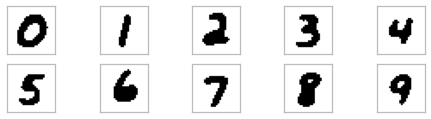

In [6]:
digit_probability = np.exp(classifier.feature_log_prob_)

fig = plt.figure(figsize=(8, 3))
inverse_digits=np.ones((10,784))
for i in range(10):
    inverse_digits[i]= digit_probability[i] < 0.5     # reverse digits 
    # plot digits
    ax = fig.add_subplot(3, 5, 1 + i, xticks=[], yticks=[])
    ax.imshow(inverse_digits[i].reshape((28,28)),cmap=pyplot.get_cmap('gray') )

# try to predict inverse digits:
y_pred_inverse=classifier.predict(inverse_digits)
print('example of the result of classifiying black over white samples:\n', y_pred_inverse)

#### Plot the confusion matrix of your classifier, as claculated on the test data (it is recommended to use sklearn.metrics.confusion_matrix). Calculate the total accuracy (fraction of correctly classified images), and summarize the results in your own words.


In [7]:
### change to generatl name
def check_misclassified(categories, category_idx, row):
    
    row_in_matrix = row.copy()
    total_appearances_of_category = np.sum(row_in_matrix)
    row_in_matrix[category_idx] = 0  # remove correct classifications
    total_errors = np.sum(row_in_matrix)
    percent_errors = np.round(total_errors/ total_appearances_of_category, 2) * 100
    
    print(f'\ntotal errors for category {categories[category_idx]} (it was classified as something else) = {total_errors} ({percent_errors:.1f}%)')
    most_confused_with_idx = np.argmax(row_in_matrix)
    most_confused_with = categories[most_confused_with_idx]
    times_confused_with = row_in_matrix[most_confused_with_idx]
    percent_from_all_these_errors = times_confused_with / total_errors * 100
    print(f'most common misclassification is: {most_confused_with}  - {times_confused_with} times ({percent_from_all_these_errors:.2f}%)')

    
def plot_conf_matrix(matrix, target_names, size = (22,22), rotation = 45):    
    ''' Plot the confusion matrix'''

    fig, ax1 = plt.subplots(figsize=size)     
    df = DataFrame(matrix, index=target_names, columns=target_names)
    df.index.name = 'Actual'
    ax = sns.heatmap(df, cmap='Blues', annot=True, fmt="d")
    ax.set_title('Confusion matrix', fontsize = 20)
    ax.set_xlabel('Predicted')
    ax.set_xticklabels(ax.get_xticklabels(), rotation = rotation, fontsize = 12)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize = 12)
    plt.tight_layout() 
    plt.show()


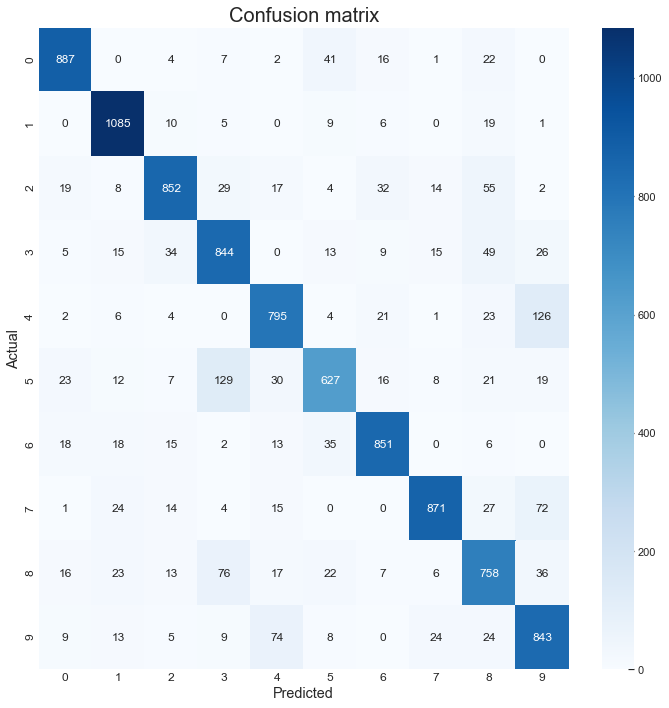

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       980
           1       0.90      0.96      0.93      1135
           2       0.89      0.83      0.86      1032
           3       0.76      0.84      0.80      1010
           4       0.83      0.81      0.82       982
           5       0.82      0.70      0.76       892
           6       0.89      0.89      0.89       958
           7       0.93      0.85      0.89      1028
           8       0.75      0.78      0.77       974
           9       0.75      0.84      0.79      1009

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [8]:
from sklearn.metrics import confusion_matrix, classification_report
from pandas import DataFrame


labels = range(10)
confustion_mat = confusion_matrix(y_test, y_test_pred)
plot_conf_matrix(confustion_mat, labels, (10,10), 0)

print(classification_report(y_test, y_test_pred, labels=labels))

In [9]:
# analyze common misclassifications
for i in labels:
    check_misclassified(labels, i, confustion_mat[i])



total errors for category 0 (it was classified as something else) = 93 (9.0%)
most common misclassification is: 5  - 41 times (44.09%)

total errors for category 1 (it was classified as something else) = 50 (4.0%)
most common misclassification is: 8  - 19 times (38.00%)

total errors for category 2 (it was classified as something else) = 180 (17.0%)
most common misclassification is: 8  - 55 times (30.56%)

total errors for category 3 (it was classified as something else) = 166 (16.0%)
most common misclassification is: 8  - 49 times (29.52%)

total errors for category 4 (it was classified as something else) = 187 (19.0%)
most common misclassification is: 9  - 126 times (67.38%)

total errors for category 5 (it was classified as something else) = 265 (30.0%)
most common misclassification is: 3  - 129 times (48.68%)

total errors for category 6 (it was classified as something else) = 107 (11.0%)
most common misclassification is: 5  - 35 times (32.71%)

total errors for category 7 (it was

***
The classifier's accuracy is 0.841, which is pretty good. The accuracy is similar for train data and test data , so it doesn't seem like it is overfitting and overall the generalization of the model is good. 

Looking at recall scores - the classifier identifies most ones and zeros (0.96 and 0.91), and the digits who gets misclassified most are 5 (recall of 0.7) and 8 (0.78) - which means 30% of 5's are classified  incorrectly and 22% of 8's are classified incorrectly.  


In terms of percision: The classifier works best for 1's and 0's (0.9 and 0.91), which means that out of all 1's and 0's the model is classifying, 90% of 1's are indeed 1's and 91% of 0's are indeed 0's. The lowest percision scores are for digits 8,9 and 3's, which only about 75% of them turn out to be a correct prediction


Looking at the confusion matrix:
5's classified as 3's and 4 classified as 9's are the most common errors (in terms of number of errors)
and followed by 8's recognized as 3's, 9's as 4's and 7's as 9's. 
***

#### Plot the mean image of each class (estimated 𝑝̂𝑗𝑖) ) and generate one sample of each class (remember, you can do this since this is a generative model). You will need to access the feature_log_prob_ attribute of the trained model.

In [10]:
def plot_samples(prob_matrix):
    fig=plt.figure(figsize=(10,4))
    rows = 2
    columns = 5

    for i in labels:
        fig.add_subplot(rows, columns, i + 1, xticks=[], yticks=[])
        image_fi = np.reshape(prob_matrix[i], (28,28))
        plt.imshow(image_fi, cmap='gray')
    plt.show()



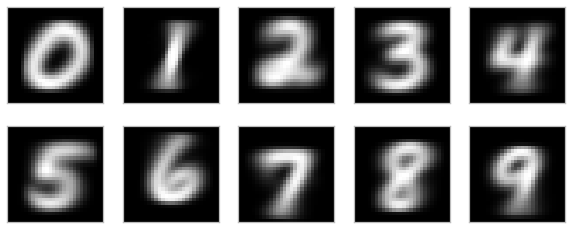

In [11]:
# using our calculated conditional probabilities per class
plot_samples(per_cluster_pixels_prob)


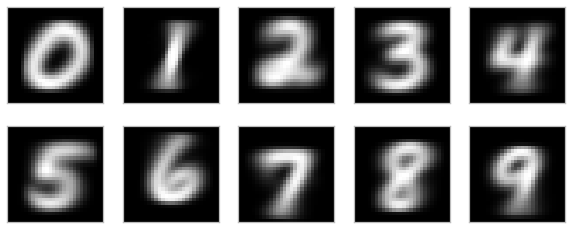

In [12]:
# using feature_log_prob_ of the trained model
feature_proba = np.exp(classifier.feature_log_prob_)
plot_samples(feature_proba)


#### To test our plotting, let's train the model with different number of examples and see how the mean images change

train size = 50 examples


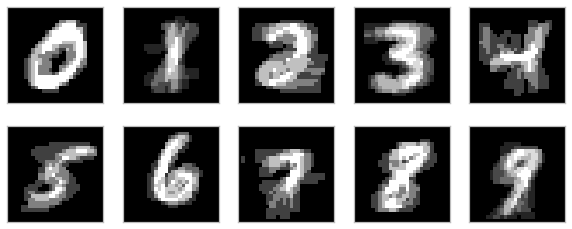

train size = 100 examples


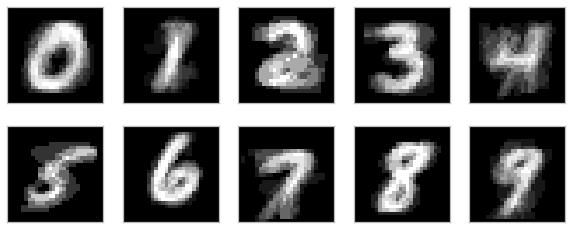

train size = 1000 examples


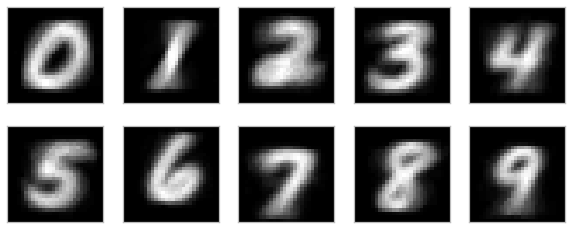

train size = 5000 examples


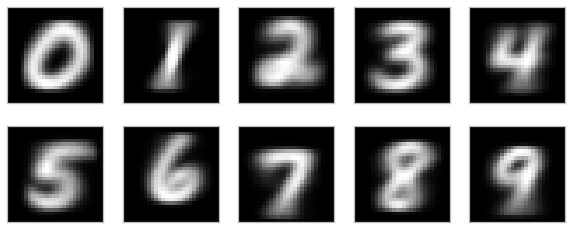

In [13]:
full_size = x_train.shape[0]
train_sizes = [50,100,1000, 5000]

for size in train_sizes:

    classifier = BernoulliNB()
    classifier.fit(x_train[:size], y_train[:size])

    # using feature_log_prob_ of the trained model
    feature_proba = np.exp(classifier.feature_log_prob_)
    print(f'train size = {size} examples')
    plot_samples(feature_proba)


####  generate one sample of each class

1 experiments:


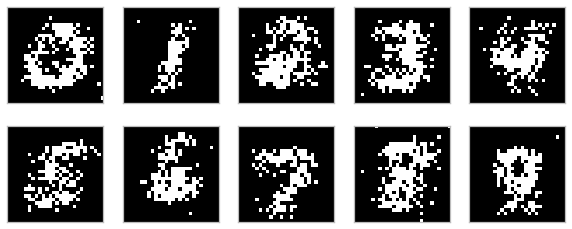

10 experiments:


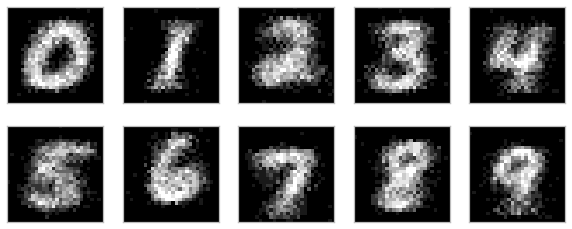

100 experiments:


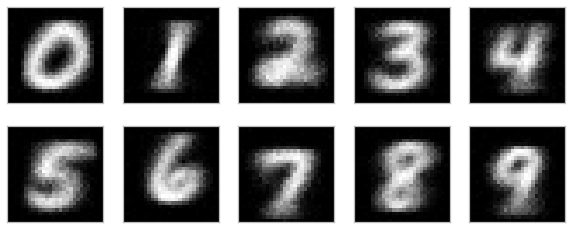

1000 experiments:


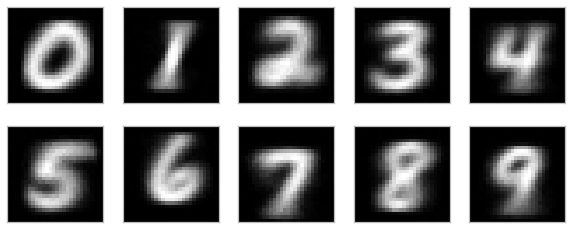

In [14]:
from numpy.random import binomial

feature_proba = np.exp(classifier.feature_log_prob_)

rows = 2
columns = 5
experiments = [1,10,100,1000]

for num_experiments in experiments:
    fig=plt.figure(figsize=(10,4))
    print(f'{num_experiments} experiments:')
    for label in labels:
        pixels = []
        for pixel in range(x_train.shape[1]):
            p = feature_proba[label][pixel]
            pix_value = np.mean(binomial(1,p, num_experiments))
            pixels.append(pix_value)

        fig.add_subplot(rows, columns, label + 1, xticks=[], yticks=[])    
        image_fi = np.reshape(np.array(pixels), (28,28))
        plt.imshow(image_fi, cmap='gray')

    plt.show()




#### Think of a way you can find the optimal threshold of the binarization part. There is no need to actually perform this task --- just describe what you would have done.

We can treat this as other hyper-parameters tuning and find the value using manual tuning or GridSearch using CV.

In [15]:
from sklearn.model_selection import GridSearchCV

# Using GridSearch

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)

model = BernoulliNB()
hyper_params = dict(binarize = np.linspace(0, 255, 10))

grid = GridSearchCV(model, hyper_params, cv = 3, n_jobs = 10)
best_parameters = grid.fit(x_train, y_train)

print(best_parameters.best_params_)

{'binarize': 85.0}


#### let's use the value we got from GridSearch

In [16]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)

model = BernoulliNB(binarize=85)
model.fit(x_train, y_train)

y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)

acc_score = accuracy_score(y_train, y_train_pred)
print(f'Model accuracy (Train) {acc_score:.3f}')
acc_score = accuracy_score(y_test, y_test_pred)
print(f'Model accuracy (Test) {acc_score:.3f}')

Model accuracy (Train) 0.836
Model accuracy (Test) 0.844


***
Using Binarize value of 85, imrpves the he model's accuracy on the test data very slightly (0.841 -> 0.844)
***

## 2. Classifing Text Documents using Multinomial Naive Bayes
In this exercise you will classify the "20 newsgroups" data set using your own naive bayes classifier and compare to the scikit learn built in version.

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon messages posted before and after a specific date.


* Load the **train** data using `from sklearn.datasets import fetch_20newsgroups`. remove headers, footers and quotes (see documentation)
* Use `sklearn.feature_extraction.text import CountVectorizer` to count words (stop_words='english')
* Write a class `NaiveBayes(BaseEstimator, ClassifierMixin)` and implement its `fit`, `predict` and `predict_proba` methods.
* use `sklearn.pipeline.make_pipeline` to chain the vectroizer and model.
* note: limit the vocuabolary size if you suffer memory issues
* compare the accuracy over the **test** data. You can use `accuracy_score, classification_report`
* compare to the built in `sklearn.naive_bayes.MultinomialNB`
* compare to `TfidfVectorizer` preprocessing (you can use the built in model for doing the analysis)
* plot the learning curve - is the model in the bias or variance regime (you can use the built in model for doing the analysis)
* optimize performance in respect to vectorizer hyper parameters (e.g. max_features, max_df etc.).



### Load the fetch_20newsgroups dataset

In [17]:
from sklearn.datasets import fetch_20newsgroups

RAND_STATE = 1

remove_metadata = ('headers', 'footers', 'quotes')
train_data = fetch_20newsgroups(subset='train', remove=remove_metadata, random_state= RAND_STATE)
x_test, y_test = fetch_20newsgroups(subset='test', return_X_y=True, remove=remove_metadata, random_state=RAND_STATE)

x_train, y_train = train_data.data, train_data.target
categories = train_data.target_names

print(len(x_train), 'docs in train set')
print(len(x_test), 'docs in test set')

11314 docs in train set
7532 docs in test set


### Implenentation of Multinomial Naive Bayes

In [18]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
from scipy.sparse import find

class NaiveBayes(BaseEstimator, ClassifierMixin):

    def __init__(self):
        self.words_cond_prob = []  # for each feature - cond prob list (entry per class)
        self.EPSILON = 1
        self.classes_priors = None
        self.classes = None
        self.features_count = None
        self.words_cond_prob = None

    def fit(self, X, y):

        self.classes, classes_counts = np.unique(y, return_counts=True)
        dataset_size = len(y)
        classes_count = len(self.classes)
        self.features_count = X.shape[1]

        self.classes_priors = np.array(classes_counts / dataset_size)

        # sum up the counts of each feature / word for each class:
        self.words_cond_prob = np.zeros(shape=(classes_count, self.features_count))  # classes X features
        count_words_per_class = [0] * classes_count
        for class_ in self.classes:
            self.words_cond_prob[class_] = np.sum(X[y == class_], axis=0)
            count_words_per_class[class_] = np.sum(self.words_cond_prob[class_] )

        # calculate conditional probability (include smoothing)
        for i, list_count in enumerate(self.words_cond_prob):
            self.words_cond_prob[i] = np.add(list_count, self.EPSILON) / (count_words_per_class[i] + self.features_count)

        return self

    def predict_log_proba(self, X):
        y_log_prob = [0] * X.shape[0]
        for idx in range(X.shape[0]):
            y_log_prob[idx] = self.predict_point_log_proba(X[idx])
        return np.array(y_log_prob)

    def predict_proba(self, X):
        return np.exp(self.predict_log_proba(X))

    def predict(self, X):
        y_pred = []
        for idx in range(X.shape[0]):
            y_pred.append(self.predict_point(X[idx]))
        return y_pred

    def predict_point(self, x):
        log_prob_for_class = self.predict_point_log_proba(x)
        return self.classes[np.argmax(log_prob_for_class)]

    def predict_point_log_proba(self, X):
        rows_idx, cols_idx, values = find(X)
        log_proba = np.log(self.classes_priors) + np.dot(np.log(self.words_cond_prob[:, cols_idx]), values)
        return log_proba.tolist()

In [19]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline, Pipeline
from pandas import DataFrame
import seaborn as sns

sns.set()    
        
def analyze_model(y_test, y_test_pred):
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    plot_conf_matrix(conf_matrix, categories);
    
    print(classification_report(y_test, y_test_pred, target_names = categories ))

    # analyze common misclassifications
    for category_index in range(len(categories)):
        check_misclassified(categories, category_index, conf_matrix[category_index])
    

def run_and_evaluate_pipeline(x_test, y_test, x_train, y_train, pipeline, categories):

    pipeline.fit(x_train, y_train)

    y_test_pred = pipeline.predict(x_test)
    y_train_pred = pipeline.predict(x_train)

    acc_score = accuracy_score(y_train, y_train_pred)
    print(f'Model accuracy (Train) {acc_score:.3f}')
    acc_score = accuracy_score(y_test, y_test_pred)
    print(f'Model accuracy (Test) {acc_score:.3f}')

    f1 = f1_score(y_train, y_train_pred, average='weighted')
    print(f'Model accuracy weighted f1 score (Train): {f1:.3f}')

    f1 = f1_score(y_test, y_test_pred, average='weighted')
    print(f'Model accuracy weighted f1 score (Test): {f1:.3f}')

    n_features = len(pipeline.named_steps["vectorizer"].get_feature_names())
    print(f'{n_features} features')


def run_and_evaluate_model(x_test, y_test, x_train, y_train, categories, sklearn = False, tf_idf = False):
    
    if sklearn:
        title = 'SKlearn Model'
        model = MultinomialNB()
    else:
        title = 'Our Naive Bayes Model'
        model = NaiveBayes()

    if tf_idf:
        title += " (TF-IDF Vectorizer)"
        vectorizer = TfidfVectorizer(stop_words='english')
    else:
        title += " (Count Vectorizer)"
        vectorizer = CountVectorizer(stop_words='english')

    print(title)

    # Define a pipeline combining the vectorizer and the classifier
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', model),
    ])

    run_and_evaluate_pipeline(x_test, y_test, x_train, y_train, pipeline, categories)

    

### compare the accuracy over the test data

In [20]:
from time import time 

t0 = time()

run_and_evaluate_model(x_test, y_test, x_train, y_train, categories, sklearn=False)

print(f"done in { time() - t0:.2f} sec")

Our Naive Bayes Model (Count Vectorizer)
Model accuracy (Train) 0.818
Model accuracy (Test) 0.634
Model accuracy weighted f1 score (Train): 0.802
Model accuracy weighted f1 score (Test): 0.610
101322 features
done in 7.26 sec


***

We see that our test accuracy is `0.634` (vs. train accuracy which is `0.818`). Looking at weighted f1-score, the score is even lower (`0.610`). As the test accuracy is low and the difference between test and train accuracy is fairly large, we could say that the model overfits the data and does not generalize very well.

***


### compare to the built in `sklearn.naive_bayes.MultinomialNB`

In [21]:
from time import time

#  use regular vectorizer and compare to SKlearn
t0 = time()

run_and_evaluate_model(x_test, y_test, x_train, y_train, categories , sklearn=True)

print(f"done in {time() - t0:.2f} sec")


SKlearn Model (Count Vectorizer)
Model accuracy (Train) 0.818
Model accuracy (Test) 0.634
Model accuracy weighted f1 score (Train): 0.802
Model accuracy weighted f1 score (Test): 0.610
101322 features
done in 3.09 sec


***

#### We see that our model gives the same results as the built in  `sklearn.naive_bayes.MultinomialNB`

***


### compare to TfidfVectorizer preprocessing

In [22]:
#  use TDF-IF Vectorizer
t0 = time()

run_and_evaluate_model(x_test, y_test, x_train, y_train, categories, sklearn = False, tf_idf= True)
 
print(f"done in {time() - t0:.2f} sec")

Our Naive Bayes Model (TF-IDF Vectorizer)
Model accuracy (Train) 0.877
Model accuracy (Test) 0.678
Model accuracy weighted f1 score (Train): 0.871
Model accuracy weighted f1 score (Test): 0.665
101322 features
done in 7.23 sec


***

The test accuracy improved and is now `0.678` (vs. the previous `0.634`), and training accuracy is `0.877` (vs. the previous `0.818`), However, we are still overfitting. Using the TDF-IF Vectorizer did also improve the weighted f1-score to `0.665` (from `0.610`) on the test data and to `0.871` (from `0.802`) on the train data but we can see the overfitting here as well.  

***


### plot the learning curve - is the model in the bias or variance regime?


In [23]:
def plot_errors (x_axis, train_error_mean_list, valid_error_mean_list, x_label, y_label):
    
    fig=plt.figure(figsize=(15,6))
    plt.xlabel(x_label)
    plt.xticks(x_axis)
    plt.ylabel(y_label)
    plt.plot(x_axis, train_error_mean_list, label="train error", marker = 'o', c = 'g')
    plt.plot(x_axis, valid_error_mean_list, label="validation error", marker = 'o', c = 'r')

    plt.legend()
    plt.show()

In [24]:
from sklearn.model_selection import learning_curve


model = MultinomialNB()
vectorizer = TfidfVectorizer(stop_words='english')

# Define a pipeline combining the vectorizer and the classifier
pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', model),
])


train_set_size_80_percent = int(np.floor(0.8 * len(x_train)))
train_sizes = [int(np.floor(size)) for size in np.linspace(1000, train_set_size_80_percent,10)]

train_sizes, train_scores, validation_scores = learning_curve(pipeline, x_train, y_train, cv=5, n_jobs=10, 
                                                              train_sizes=train_sizes, scoring = 'accuracy')


### Plot learning curves

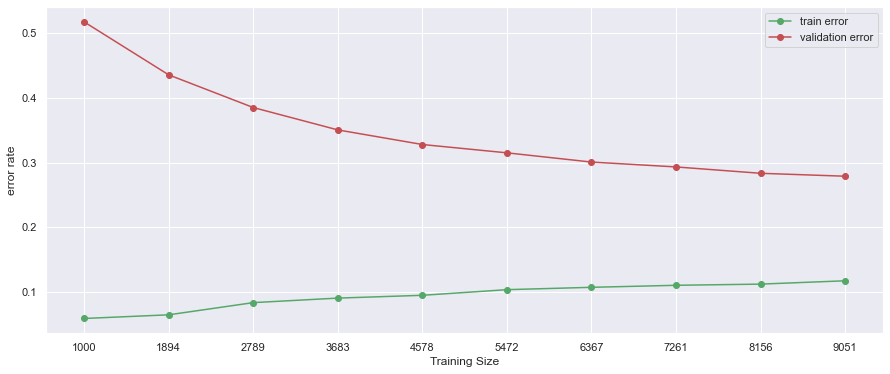

In [25]:
train_error_mean = 1 - np.mean(train_scores, axis=1)
validation_error_mean = 1 - np.mean(validation_scores, axis=1)

plot_errors (train_sizes, train_error_mean, validation_error_mean, 'Training Size', 'error rate')


***

We can see that the training error increases as we add more examples, but is overall low (max value is 0.12). This means the training data is fitted pretty well so we have a low bias. The large gap between the training and validation error (more than 15% difference) indicates a high variance and overfitting problem - the model fits the training data (too) well but doesn't generalize as well. So it has low bias - high variance.

The trend seen in the plot, where the validation error decreases as the number of training examples grows - suggests that the model hasn't seen enough data to generalize well, and adding more training examples will improve the model's accuracy and reduce validation error. The model is currently very complex (it has over 100,000 features) so it requires a lot of examples to achieve good accuracy. It might be also that the default hyper parametrs are well tuned for this data (we used default parameters) - we will check that next.
 
***

### optimize performance in respect to vectorizer hyper parameters 



#### Let's manually tune max features:

..................................................

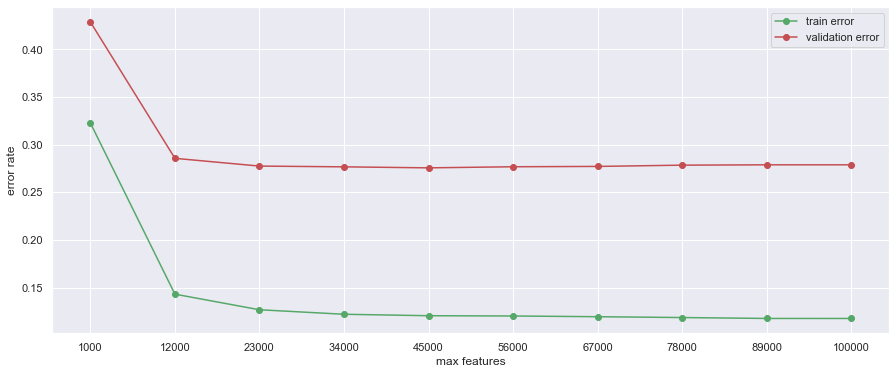

In [26]:
KFOLD_SPLITS = 5

train_error_mean_list = []
valid_error_mean_list = []

max_features = [ 1000, 12000, 23000, 34000, 45000, 56000, 67000, 78000, 89000, 100000 ]

model = MultinomialNB()

for max_f in max_features:
 
    kf = StratifiedKFold(n_splits=KFOLD_SPLITS)
    train_error_list = []
    valid_error_list = []

    for train_idx, test_idx in kf.split(x_train, y_train):

        print('.', end = '')
        
        vectorizer = TfidfVectorizer(stop_words='english', max_features = max_f)

        # Define a pipeline combining the vectorizer and the classifier
        opt_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', model),
        ])
        
        x_train_train = [x_train[i] for i in train_idx]
        y_train_train = [y_train[i] for i in train_idx]
        x_train_test =  [x_train[i] for i in test_idx]
        y_train_test =  [y_train[i] for i in test_idx]
        
        opt_pipeline.fit(x_train_train, y_train_train)
        
        y_test_pred = opt_pipeline.predict(x_train_test)
        y_train_pred = opt_pipeline.predict(x_train_train)

        train_error_list.append(1 - accuracy_score(y_train_train,y_train_pred))
        valid_error_list.append(1 - accuracy_score(y_train_test,y_test_pred))

    train_error_mean_list.append(np.array(train_error_list).mean())
    valid_error_mean_list.append(np.array(valid_error_list).mean())

plot_errors(max_features, train_error_mean_list, valid_error_mean_list, 'max features', "error rate" )


***

Seems like the validation error flattens around 12k - 23k features. let's choose 20k

***

#### Let's optimize strip_accent

In [27]:
KFOLD_SPLITS = 5

train_error_mean_list = []
valid_error_mean_list = []

strip_accents_options = ['ascii', None]

model = MultinomialNB()

for strip_accent in strip_accents_options:
 
    kf = StratifiedKFold(n_splits=KFOLD_SPLITS)
    train_error_list = []
    valid_error_list = []

    for train_idx, test_idx in kf.split(x_train, y_train):

        print('.', end = '')
        
        vectorizer = TfidfVectorizer(stop_words='english', strip_accents = strip_accent)

        # Define a pipeline combining the vectorizer and the classifier
        opt_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', model),
        ])
        
        x_train_train = [x_train[i] for i in train_idx]
        y_train_train = [y_train[i] for i in train_idx]
        x_train_test =  [x_train[i] for i in test_idx]
        y_train_test =  [y_train[i] for i in test_idx]
        
        opt_pipeline.fit(x_train_train, y_train_train)
        
        y_test_pred = opt_pipeline.predict(x_train_test)
        y_train_pred = opt_pipeline.predict(x_train_train)

        train_error_list.append(1 - accuracy_score(y_train_train,y_train_pred))
        valid_error_list.append(1 - accuracy_score(y_train_test,y_test_pred))

    train_error_mean_list.append(np.array(train_error_list).mean())
    valid_error_mean_list.append(np.array(valid_error_list).mean())

print('Done')


..........Done


In [28]:
print(train_error_mean_list)
print(valid_error_mean_list)

[0.11770812599081952, 0.11770812599081952]
[0.278947103150556, 0.278947103150556]


***

No real difference between ascii and None.

***

#### Let's manually tune max_df:

In [29]:

train_error_mean_list = []
valid_error_mean_list = []

max_df_list = [0.05, 0.1, 0.2 , 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1.0] 

model = MultinomialNB()

for max_df in max_df_list:
 
    kf = StratifiedKFold(n_splits=KFOLD_SPLITS)
    train_error_list = []
    valid_error_list = []

    for train_idx, test_idx in kf.split(x_train, y_train):

        print('.', end = '')
        
        vectorizer = TfidfVectorizer(stop_words='english', max_df =  max_df)

        # Define a pipeline combining the vectorizer and the classifier
        opt_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', model),
        ])
        
        x_train_train = [x_train[i] for i in train_idx]
        y_train_train = [y_train[i] for i in train_idx]
        x_train_test =  [x_train[i] for i in test_idx]
        y_train_test =  [y_train[i] for i in test_idx]
        
        opt_pipeline.fit(x_train_train, y_train_train)
        
        y_test_pred = opt_pipeline.predict(x_train_test)
        y_train_pred = opt_pipeline.predict(x_train_train)

        train_error_list.append(1 - accuracy_score(y_train_train,y_train_pred))
        valid_error_list.append(1 - accuracy_score(y_train_test,y_test_pred))

    train_error_mean_list.append(np.array(train_error_list).mean())
    valid_error_mean_list.append(np.array(valid_error_list).mean())

print('Done')

............................................................Done


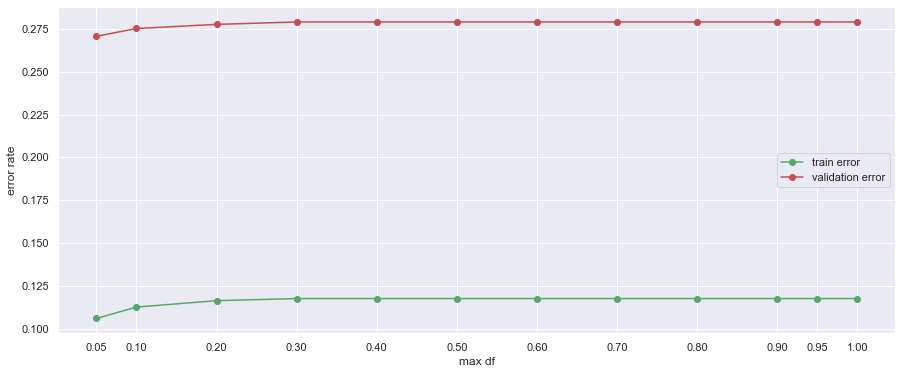

In [30]:
plot_errors(max_df_list, train_error_mean_list, valid_error_mean_list, 'max df', "error rate" )

***

Seems like lower max_df has a slightly lower error

***

#### Let's try to optimize n_grams

In [31]:
train_error_mean_list = []
valid_error_mean_list = []

ngram_list = [(1,1),(1,2), (1,3)] 

model = MultinomialNB()

for n_gram in ngram_list:
 
    kf = StratifiedKFold(n_splits=KFOLD_SPLITS)
    train_error_list = []
    valid_error_list = []

    for train_idx, test_idx in kf.split(x_train, y_train):

        print('.', end = '')
        
        vectorizer = TfidfVectorizer(stop_words='english', ngram_range =  n_gram)

        # Define a pipeline combining the vectorizer and the classifier
        opt_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', model),
        ])
        
        x_train_train = [x_train[i] for i in train_idx]
        y_train_train = [y_train[i] for i in train_idx]
        x_train_test =  [x_train[i] for i in test_idx]
        y_train_test =  [y_train[i] for i in test_idx]
        
        opt_pipeline.fit(x_train_train, y_train_train)
        
        y_test_pred = opt_pipeline.predict(x_train_test)
        y_train_pred = opt_pipeline.predict(x_train_train)

        train_error_list.append(1 - accuracy_score(y_train_train,y_train_pred))
        valid_error_list.append(1 - accuracy_score(y_train_test,y_test_pred))

    train_error_mean_list.append(np.array(train_error_list).mean())
    valid_error_mean_list.append(np.array(valid_error_list).mean())

print('Done')


...............Done


[0.278947103150556, 0.2783282209128279, 0.2817751683660532]


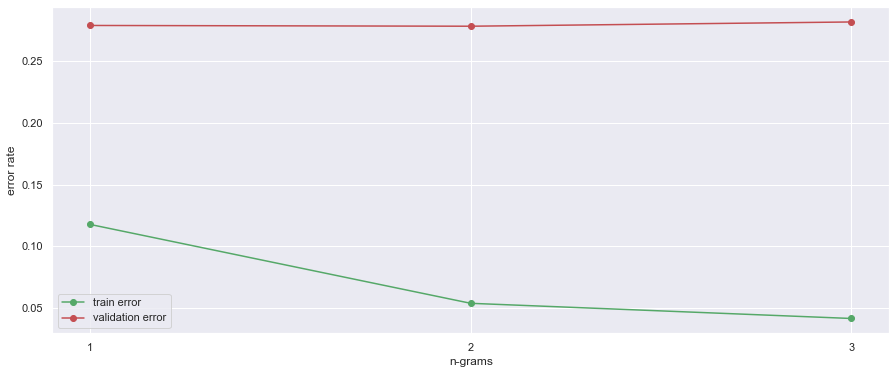

In [32]:
print(valid_error_mean_list)
plot_errors([1,2,3], train_error_mean_list, valid_error_mean_list, 'n-grams', "error rate" )

***

Seens like the training errors decreases, but validation errors don't for 2 / 3 grams. We will stays with one then.

***

#### let's try to optimize min_df

In [33]:

train_error_mean_list = []
valid_error_mean_list = []

min_df_list = [1, 10, 100, 500]

model = MultinomialNB()

for min_df in min_df_list:
 
    kf = StratifiedKFold(n_splits=KFOLD_SPLITS)
    train_error_list = []
    valid_error_list = []

    for train_idx, test_idx in kf.split(x_train, y_train):

        print('.', end = '')
        
        vectorizer = TfidfVectorizer(stop_words='english', min_df =  min_df)

        # Define a pipeline combining the vectorizer and the classifier
        opt_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', model),
        ])
        
        x_train_train = [x_train[i] for i in train_idx]
        y_train_train = [y_train[i] for i in train_idx]
        x_train_test =  [x_train[i] for i in test_idx]
        y_train_test =  [y_train[i] for i in test_idx]
        
        opt_pipeline.fit(x_train_train, y_train_train)
        
        y_test_pred = opt_pipeline.predict(x_train_test)
        y_train_pred = opt_pipeline.predict(x_train_train)

        train_error_list.append(1 - accuracy_score(y_train_train,y_train_pred))
        valid_error_list.append(1 - accuracy_score(y_train_test,y_test_pred))

    train_error_mean_list.append(np.array(train_error_list).mean())
    valid_error_mean_list.append(np.array(valid_error_list).mean())

print('Done')

....................Done


[0.278947103150556, 0.29194007469564787, 0.44387464821584927, 0.8272043284248627]


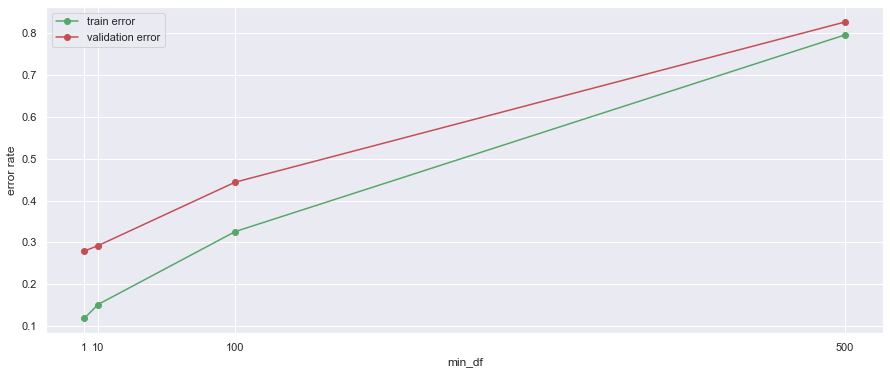

In [34]:
print(valid_error_mean_list)
plot_errors(min_df_list, train_error_mean_list, valid_error_mean_list, 'min_df', "error rate" )

***

Seems like smaller values work better. Let's stick with the default of 1 document which has the lowest error.

***

#### Let's run the model with our manually optimized hyper parameters

In [35]:
model = MultinomialNB()
opt_vectorizer = TfidfVectorizer(stop_words='english', max_features = 20000, min_df = 1, max_df = 0.05)

# Define a pipeline combining the vectorizer and the classifier
opt_pipeline = Pipeline([
    ('vectorizer', opt_vectorizer),
    ('classifier', model),
])

run_and_evaluate_pipeline(x_test, y_test, x_train, y_train, opt_pipeline, categories)

Model accuracy (Train) 0.869
Model accuracy (Test) 0.683
Model accuracy weighted f1 score (Train): 0.865
Model accuracy weighted f1 score (Test): 0.670
20000 features


*** 

#### The test accuracy is `0.683` (vs. the previous `0.678`), and training accuracy is `0.869` (vs. the previous `0.877`) - So we are not seeing a big difference and seems like the model is still overfitting. (even with only 20,000 features)


***

#### Let's try GridSearch

In [36]:
from sklearn.model_selection import GridSearchCV

model = MultinomialNB()
vectorizer = TfidfVectorizer(stop_words='english')

# Define a pipeline combining the vectorizer and the classifier
pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', model),
])

# max_df - ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words)
# max_df = 0.50 means "ignore terms that appear in more than 50% of the documents
# min_df - ignore terms that have a document frequency strictly lower than the given threshold
# min_df = 0.01 means "ignore terms that appear in less than 1% of the documents".
# max_features -  only consider the top max_features ordered by term frequency across the corpus. 

parameters = {
    'vectorizer__max_df': (0.05, 0.5, 1.0),
    'vectorizer__ngram_range': ((1,1),(1,2)),
    'vectorizer__max_features': (None, 5000, 20000, 50000, 100000),
    'vectorizer__strip_accents': ('ascii', None),
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=10, verbose=1)

print("parameters:", parameters)


t0 = time()

best_parameters = grid_search.fit(x_train, y_train)

print(f'done in {time() - t0:.2f} sec')

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters:", best_parameters.best_params_)


parameters: {'vectorizer__max_df': (0.05, 0.5, 1.0), 'vectorizer__ngram_range': ((1, 1), (1, 2)), 'vectorizer__max_features': (None, 5000, 20000, 50000, 100000), 'vectorizer__strip_accents': ('ascii', None)}
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
/Users/noa/Documents/Y-Data/Fall 2/Supervised learning/venv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   14.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 300 out of 300 | elapsed:  2.0min finished


done in 123.81 sec
Best score: 0.736
Best parameters: {'vectorizer__max_df': 0.05, 'vectorizer__max_features': 100000, 'vectorizer__ngram_range': (1, 2), 'vectorizer__strip_accents': 'ascii'}


#### let's try to run the model with the optimized parameters

In [37]:
model = MultinomialNB()
opt_vectorizer = TfidfVectorizer(stop_words='english', max_df = 0.05, max_features = 100000, 
                                 ngram_range = (1, 2), strip_accents='ascii')

# Define a pipeline combining the vectorizer and the classifier
opt_pipeline = Pipeline([
    ('vectorizer', opt_vectorizer),
    ('classifier', model),
])

run_and_evaluate_pipeline(x_test, y_test, x_train, y_train, opt_pipeline, categories)

Model accuracy (Train) 0.905
Model accuracy (Test) 0.687
Model accuracy weighted f1 score (Train): 0.903
Model accuracy weighted f1 score (Test): 0.674
100000 features


*** 

#### The test accuracy is `0.687` (vs. the previous `0.678`), and training accuracy is `0.905` (vs. the previous `0.877`) - So we are not seeing a big difference and seems like the model is still overfitting.

***

### Optional: Model interpretability
Find the most important features for a **specific** decision of a NB classifier.
Because the model has learned the prior $p(x_i|c)$ during the training, the contribution of an individual feature value can be easily measured by the posterior, $p(c|x_i)=p(c)p(x_i|c)/p(x_i)$
Implement a function which gets a scikit-learn NB model as input and returns $P(c|x_i)$:

`def calc_p_c_given_xi(model)`

Hint: Use the following model properties:

* `model.class_log_prior_`
* `model.feature_log_prob_`

Note: remember these are logs and you need to use np.exp and normalize to get $P(c|x_i)$ 
Another hint: use numpy built-in broadcasting property.

* Use the interpretation to examine errors of the classifier where $\hat{c}\ne c$. Which top words support the correct class and which support the wrong class? You can use the `print_txt` below to color words. 

Bonus: How can you correct the analyzed error? 

To read more about model interpretation, see the blogpost below and my tutorial:
* https://lilianweng.github.io/lil-log/2017/08/01/how-to-explain-the-prediction-of-a-machine-learning-model.html
* https://github.com/chanansh/right_but_why

In [38]:
import string
import re

def print_txt(txt, hot, cold):
    """ print the text, coloring hot and cold words with colors    """
    
    cold_color = '\x1b[41;37m{}\x1b[0m'
    hot_color = '\x1b[42;37m{}\x1b[0m'
    mid_color = '\x1b[44;37m{}\x1b[0m'

    def color(token):
        lower = str(token).lower()
        lower = lower.replace('\t', '').replace('\n', '')
        lower = lower.translate(string.punctuation)
        if (lower in hot) and (lower in cold):
            return mid_color.format(token)
        elif lower in hot:
            return hot_color.format(token)
        elif lower in cold:
            return cold_color.format(token)
        else:
            return token

    for punctuation in string.punctuation:
        txt = txt.replace(punctuation, '')

    txt = txt.replace('\n', ' ')
    txt = txt.replace('\t', ' ')
    
    colored_txt = " ".join([color(token) for token in txt.split(' ')])
    
    print(colored_txt)
    
print_txt('This word support the first class but this the other', ['word', 'first'], ['other', 'first'])


This word support the first class but this the other


### Implement a function which gets a scikit-learn NB model as input and returns  𝑃(𝑐|𝑥𝑖)

In [39]:
import numpy as np
import pandas as pd
import string
  
def calc_p_c_given_xi(model):
    ''' return matrix of individual feature values (which can be measured by the posterior p(y| Xi))'''
    
    p_c = np.exp(model.class_log_prior_)
    p_xi_given_c = np.exp(model.feature_log_prob_)
    p_c_times_p_c_given_xi = np.expand_dims(p_c, axis = -1) * p_xi_given_c
    p_xi = np.sum(p_c_times_p_c_given_xi, axis = 0)
    p_c_given_xi = p_c_times_p_c_given_xi / p_xi

    return p_c_given_xi


### Find the most important features for a specific decision of a NB classifier. 
### Use the interpretation to examine errors of the classifier. Which top words support the correct class and which support the wrong class? You can use the print_txt below to color words.

#### Helper functions

In [40]:
def create_dfs_for_features_value(model, vectorizer, categories):
    ''' Create two dataframes for the class probabilities given a feature (single index and multi index)
    This will help determine features importance '''
    
    
    # calculate the posterior matrix
    class_p_given_a_feature = calc_p_c_given_xi(model)

    # create a multi index df (word index + word)
    class_p_given_a_feature_df = pd.DataFrame(class_p_given_a_feature.T, 
                                                          index = vectorizer.vocabulary_.items(), 
                                                          columns = categories)
    class_p_given_a_feature_df.index.names = ['word', 'idx']
    
    # create a single index df (word index)
    class_p_given_a_feature_df_single_ind = pd.DataFrame(class_p_given_a_feature.T, 
                                                         index = vectorizer.vocabulary_.values(), 
                                                         columns = categories)
    class_p_given_a_feature_df_single_ind.index.name = 'index'

    return class_p_given_a_feature_df, class_p_given_a_feature_df_single_ind


def print_highest_prob_words_for_class(prob_mi_df, c, n):
    ''' show top n keywords for a class (words with highest probability - p(c | Xi)'''
    
    print(f'Top {n} keywords for category {categories[c]}:')
    print(prob_mi_df.nlargest(n, categories[c])[categories[c]])


def get_top_doc_words_per_c(prob_df, features, label, word_idx, min_prob = 0.05, top_n = 10):
    """ return highest p(c|xi) for the given class and word indices """
    
    word_indices = [ind for ind in word_idx]
    # get the score for all the words in this document and filter out words with p < min_prob
    
    word_scores = prob_df.loc[word_indices][categories[label]]
    word_scores = word_scores.where(word_scores > min_prob)
    
    # translate to the actual words
    words =[features[i] for i in word_indices]
    
    # create a dataframe of words and their probability and index and sort by score
    df = pd.DataFrame({'word':words, 'probability':word_scores}, index = word_indices)
    df.index.name = 'index'
    df.sort_values(by=['probability'], ascending = False)
    
    df = df.dropna()

    return df[:top_n]
    
    
def analyze_prediction(x_test_tfidf_arr, y_test, features, prob_df, prob_mi_df, idx, min_prob, top_n = 20):
    """ analyze a specific classifier prediction in terms of words that impacted the descision the most"""
    
    doc_text = x_test[idx]
    x_tf_df_vec = x_test_tfidf_arr[idx]
    doc_words_idx = (x_tf_df_vec.nonzero()[0]).tolist()
    
    real_label = y_test[idx]
    predicted_label = y_pred_test[idx]
        
    print(f'\n\nLabel      = {categories[real_label]} ({real_label})')
    print(f'Prediction = {categories[predicted_label]} ({predicted_label})')
    print(f'** {real_label == predicted_label} Prediction **')
    print()
        

    print('Hot words that support the correct classification', categories[real_label])
    hot_words_series = get_top_doc_words_per_c(prob_df, features, real_label, doc_words_idx, min_prob, top_n);
    display(hot_words_series);

    if predicted_label != real_label:
        print('Cold words - that support the incorrect predicted class ', categories[predicted_label])
        cold_words_series = get_top_doc_words_per_c(prob_df, features, predicted_label, doc_words_idx, min_prob, top_n);
        cold_words_list = cold_words_series.word.tolist()
        display(cold_words_series);
    else:
        cold_words_list = []
    
    print()
    print_txt(doc_text, hot_words_series.word.tolist(), cold_words_list)

    print('\nReal class: ')
    print('**************')
    print(print_highest_prob_words_for_class(prob_mi_df, real_label, top_n))

    if predicted_label != real_label:
        print('\nPredicted class: ')
        print('*******************')
        print(print_highest_prob_words_for_class(prob_mi_df, predicted_label, top_n))



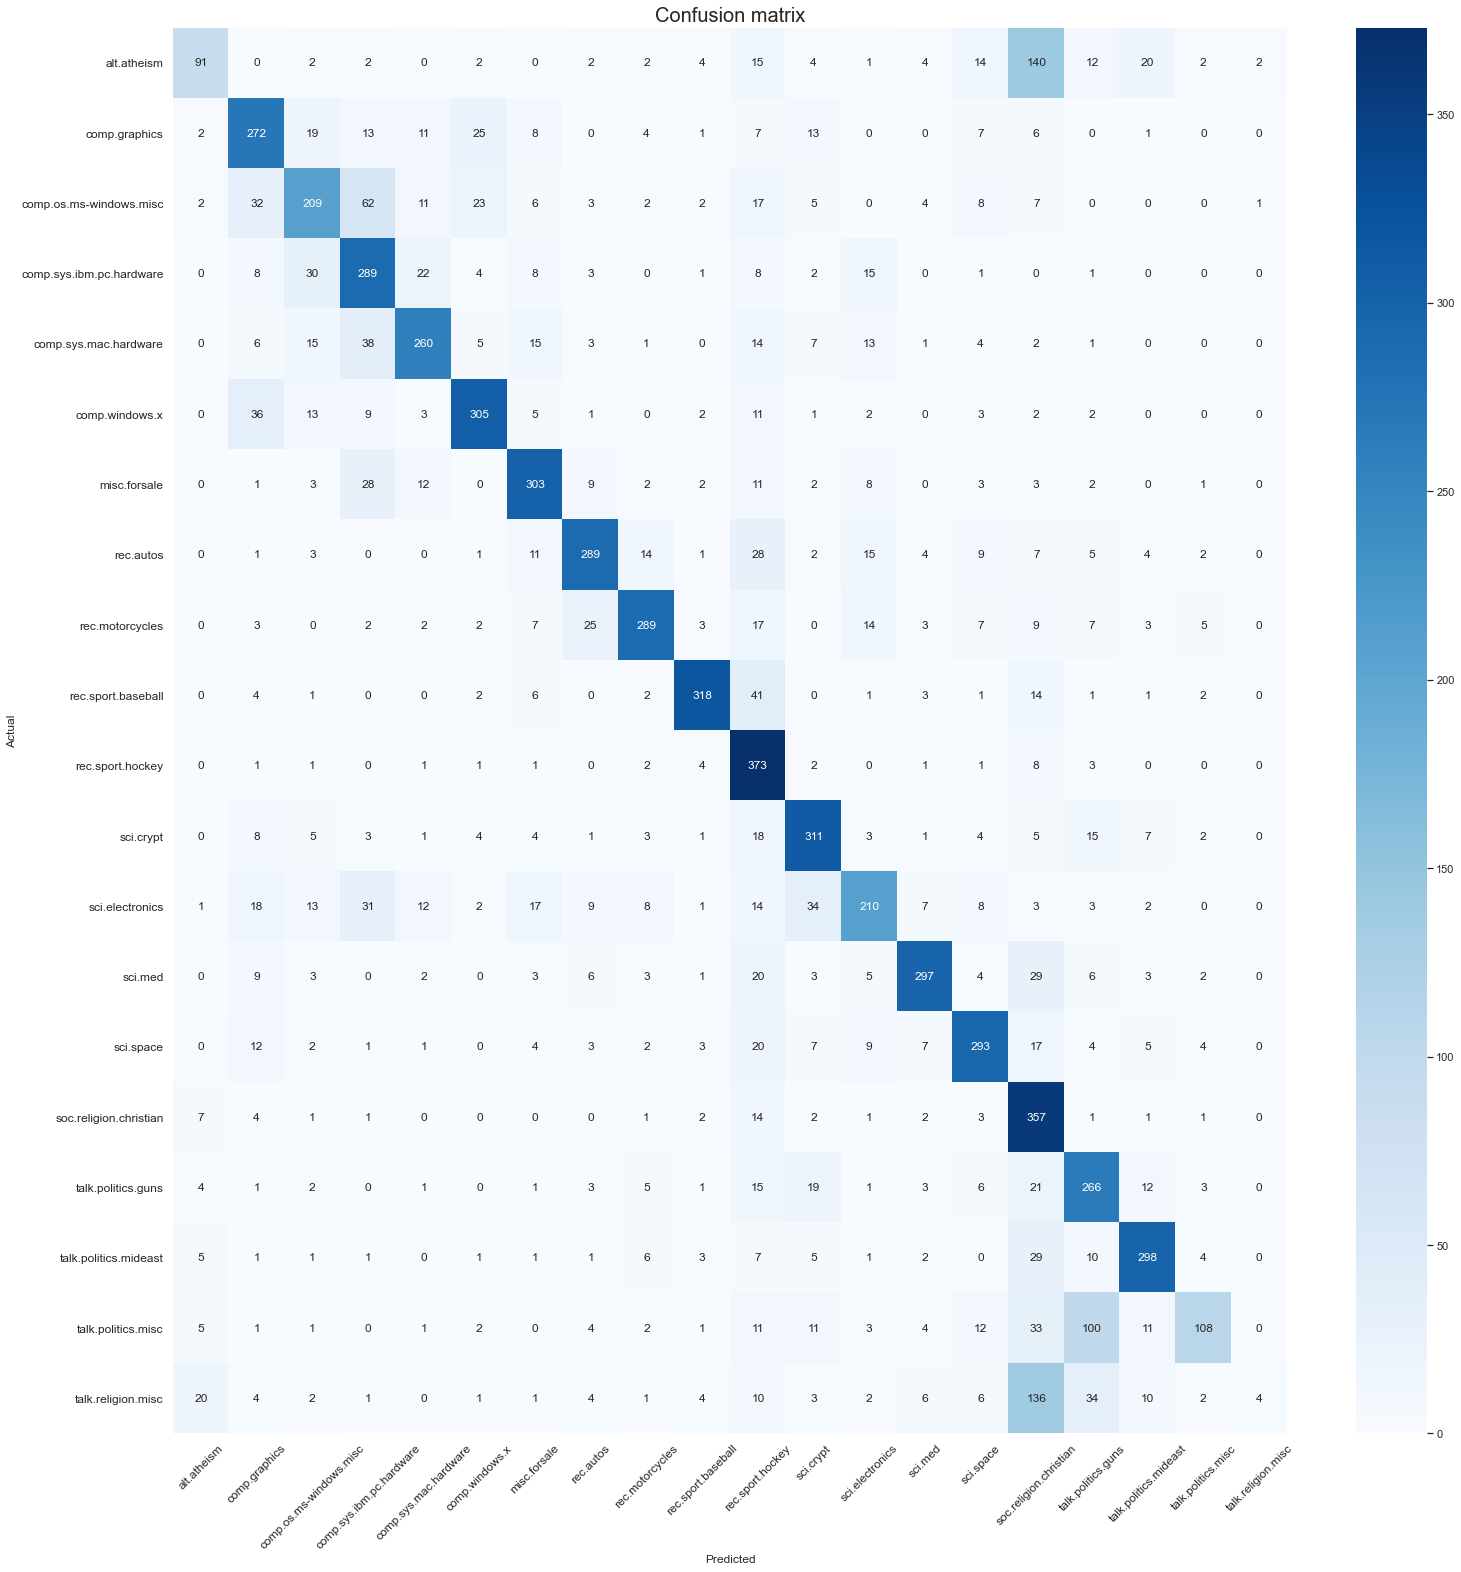

                          precision    recall  f1-score   support

             alt.atheism       0.66      0.29      0.40       319
           comp.graphics       0.64      0.70      0.67       389
 comp.os.ms-windows.misc       0.64      0.53      0.58       394
comp.sys.ibm.pc.hardware       0.60      0.74      0.66       392
   comp.sys.mac.hardware       0.76      0.68      0.72       385
          comp.windows.x       0.80      0.77      0.79       395
            misc.forsale       0.76      0.78      0.77       390
               rec.autos       0.79      0.73      0.76       396
         rec.motorcycles       0.83      0.73      0.77       398
      rec.sport.baseball       0.90      0.80      0.85       397
        rec.sport.hockey       0.56      0.93      0.70       399
               sci.crypt       0.72      0.79      0.75       396
         sci.electronics       0.69      0.53      0.60       393
                 sci.med       0.85      0.75      0.80       396
         

In [41]:
# let's create a model and run it so we can look at its descisions

model = MultinomialNB()
vectorizer = TfidfVectorizer(stop_words='english', max_df = 0.05, max_features = 20000)
x_train_tfidf = vectorizer.fit_transform(x_train, y_train)
x_test_tfidf = vectorizer.transform(x_test)
x_test_tfidf_arr = x_test_tfidf.toarray()

features = np.array(vectorizer.get_feature_names())

model.fit(x_train_tfidf,y_train)
y_pred_test = model.predict(x_test_tfidf)

c_p_given_xi_df, c_p_given_xi_ind_df = create_dfs_for_features_value(model, vectorizer, categories)

analyze_model(y_test, y_pred_test)

As seen from the confusion matrix above there are few common confusions. The 2 most common ones are missclassifying of the atheism (class 0, 188 cases) and religion.misc ( class 19, 167 cases) classes as religion.christian (15). This is quite reasonable actually as these 3 classes actually deal with the same subjects maybe just from differnt angles and share probably the same vocabulary and concepts. Note that the complement missclassification  - religion.christian as atheism or religion.misc is very rare (just one case). This might be because the religion.christian class has much more samples than the other 2 classes and hence more words related to it as seen in the 2 plots below. Also the subject religion.christian is more specific from the other two and hence maybe easier to distingish it.




***

Looking at these results, we can see that the highest % of misclassifications happens for  `talk.religion.misc ` (98%) and for `alt.atheism` (71%) which both are often misclassified as something else. Both are most frequently classified as  `soc.religion.christian`. This is quite reasonable, as these three classes deal with similar concepts and probably share the same vocabulary. 

Note that the complement missclassification  - `soc.religion.christian` as `alt.atheism` or `talk.religion.misc` is very rare. This might happen because the `soc.religion.christian` class has more samples than the other 2 classes and hence more words related to it, as seen in the 2 plots below. Also the subject `soc.religion.christian` is more specific from the other two and hence maybe easier to distingish it.

***

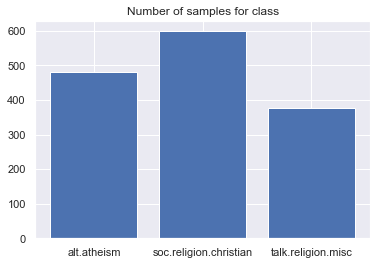

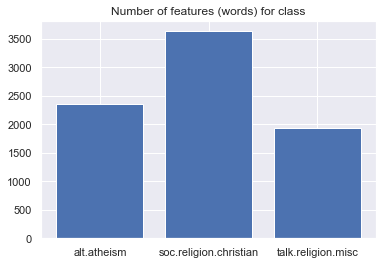

In [42]:
checked_categories_idx = [0, 15, 19]
checked_categories = [categories[i] for i in checked_categories_idx]
samples_count = [model.class_count_[i] for i in checked_categories_idx]

feature_count = [model.feature_count_[i] for i in checked_categories_idx]

plt.bar(checked_categories, samples_count)
plt.xticks(checked_categories)
plt.title('Number of samples for class')
plt.show()

class_features = np.sum(feature_count, axis=1)
plt.bar(checked_categories, class_features)
plt.xticks(checked_categories)
plt.title('Number of features (words) for class')
plt.show()

Another common mistake is missclassifying `talk.politics.misc` as `talk.politics.guns`. This confusion is less trivial than the previous ones. Again `talk.politics.guns` is more specific and has more samples but the differnce is less clear so we will explore it using the posterior probabilities and the supporting words method.

In [50]:
pd.set_option('display.max_rows', 105)

def find_err_for_class(model, x_test, vectorizer, y_pred, y_true, true_class, target_names):
    ''' For each missclassification of a given class, show the top words that supported the right and wrong 
        classification and their posterior probabilities'''
    
    p_c_w = calc_p_c_given_xi(model)
    key_list = list(vectorizer.vocabulary_.keys()) # words
    val_list = list(vectorizer.vocabulary_.values()) # words indices
       
    err_ind, = np.where((y_true==true_class) & (y_pred!=true_class))
        
    support_for_class = np.empty((err_ind.size,6), dtype=object)    
    incorerctly_classified_docs = x_test[err_ind]    
    
    
    for j in range(incorerctly_classified_docs.shape[0]):
        
        ind_feat, = np.where(incorerctly_classified_docs[j]>0)
        
        wrong_class = y_pred[err_ind[j]]
        if ind_feat.size==0:
            support_for_class[j] = None
        else:
            highest_p_c_given_xi = ind_feat[np.argmax(p_c_w[true_class, ind_feat])]
            max_wrong = ind_feat[np.argmax(p_c_w[wrong_class, ind_feat])]
            line = np.array([target_names[true_class], 
                             target_names[wrong_class],
                             key_list[val_list.index(highest_p_c_given_xi)],
                             np.round(np.max(p_c_w[true_class,ind_feat]), decimals=3),
                             key_list[val_list.index(max_wrong)], 
                             np.round(np.max(p_c_w[wrong_class,ind_feat]), decimals=3)])
        
        support_for_class[j]= line
        
    return support_for_class


ind_of_politics_misc = 18
columns_for_df = ['correct class', 'wrong prediction class', 'support correct class','prob_class', 'support wrong class','prob_wrong']

error_analysis = find_err_for_class(model, x_test_tfidf_arr, vectorizer, y_pred_test, y_test, ind_of_politics_misc, categories)
df = pd.DataFrame(error_analysis, columns = columns_for_df)  
df=df.dropna(axis=0)
display(df[df['wrong prediction class'] == 'talk.politics.guns'] ) 



,correct class,wrong prediction class,support correct class,prob_class,support wrong class,prob_wrong
0,talk.politics.misc,talk.politics.guns,liberal,0.101,waco,0.214
4,talk.politics.misc,talk.politics.guns,government,0.137,gun,0.51
5,talk.politics.misc,talk.politics.guns,government,0.137,gun,0.51
6,talk.politics.misc,talk.politics.guns,force,0.106,compound,0.213
8,talk.politics.misc,talk.politics.guns,national,0.081,military,0.123
10,talk.politics.misc,talk.politics.guns,drugs,0.178,criminals,0.218
11,talk.politics.misc,talk.politics.guns,government,0.137,davidians,0.178
12,talk.politics.misc,talk.politics.guns,president,0.191,gun,0.51
15,talk.politics.misc,talk.politics.guns,government,0.137,government,0.14
16,talk.politics.misc,talk.politics.guns,president,0.191,fbi,0.305


*** 
We can see that many of the errors are actually quite reasonable as the missclassified documents contain words like: gun, guns, weapons, fbi, etc., which are, naturally, strong predictors (probability >=0.3) of the politics.guns class. 

This is in fact a well known flaw of the Naive bayes algorithm that takes words as indepndent features and ignores dependecies between words (context).

It might be that taking also n-grams of higher range such as 4 or 5 may help with adding more context but this will also increase the number of features. 

Another option might be using Bernoullie classifier instead of multinomial as it calculates the probability also of words that do not appear in the specific document but appear in the vocublary. It consides the probability of not-seeing these words given the class whereas the multinomial classifiers ignores them.
                                                                                                                   
***

### Let's explore more errors:

In [51]:
import ipywidgets as widgets
from ipywidgets import interact, fixed

def show_sliders(y_test, x_test_tfidf_arr, features, c_p_given_xi_ind_df, c_p_given_xi_df):
    example_ind = widgets.IntSlider(min=0, max = len(y_test), value=5496, continuous_update=False)
    min_prob = widgets.FloatSlider(min=0.01, max = 0.2, step = 0.01, value = 0.05, continuous_update=False)
    top_words = widgets.IntSlider(min=0, max = 30,  value = 10, continuous_update=False)
    interact(analyze_prediction, idx = example_ind, min_prob = min_prob, top_n = top_words, 
            x_test_tfidf_arr = fixed(x_test_tfidf_arr), y_test = fixed(y_test), features = fixed(features), 
            prob_df = fixed(c_p_given_xi_ind_df), prob_mi_df = fixed(c_p_given_xi_df));

In [52]:
show_sliders(y_test, x_test_tfidf_arr, features, c_p_given_xi_ind_df, c_p_given_xi_df)

interactive(children=(IntSlider(value=5496, continuous_update=False, description='idx', max=7532), FloatSlider…

*** 

Let's look at example 5496, which is `comp.graphics` misclassified as `comp.sys.ibm.pc.hardware`
Looking at the features which impact this descision most - we can see that most words that impacted the classification descision are not even words, but mostly numbers. Let's try to improve the model by adding pre-processing
***

*** 

__Which top words support the correct class and which support the wrong class?__
we can see the green words that support the real class, the red ones that support the predicted class and the blue ones that appear in both.

***

### How can you correct the analyzed error?

***

We can try to use a pre-processor to improve the classifier

***

In [53]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from time import time
import nltk
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")

def tokenizer(text):
    
    text = text.lower()
    # remove special characters and digits
    text = re.sub('[^a-zA-Z]+', ' ', text)
    tokens = word_tokenize(text)
    words = []
    for token in tokens:
        if token not in stopwords.words('english') and len(token) > 1:
            words.append(stemmer.stem(token))
            
    return tokens


# pp indicates = pre processed text

model_pp = MultinomialNB()
vectorizer_pp = TfidfVectorizer(stop_words='english', tokenizer = tokenizer, max_df = 0.05)

t0 = time()

x_train_tfidf_pp = vectorizer_pp.fit_transform(x_train, y_train)
x_test_tfidf_pp = vectorizer_pp.transform(x_test)
x_test_tfidf_arr_pp = x_test_tfidf_pp.toarray()

print(f"done in {time() - t0:.2f} sec")

features_pp = np.array(vectorizer_pp.get_feature_names())

model_pp.fit(x_train_tfidf_pp,y_train)
y_pred_test_pp = model_pp.predict(x_test_tfidf_pp)
y_pred_train_pp = model_pp.predict(x_train_tfidf_pp)


done in 527.80 sec


In [54]:

acc_score = accuracy_score(y_train, y_pred_train_pp)
print(f'Model accuracy (Train) {acc_score:.3f}')
acc_score = accuracy_score(y_test, y_pred_test_pp)
print(f'Model accuracy (Test) {acc_score:.3f}')

f1 = f1_score(y_train, y_pred_train_pp, average='weighted')
print(f'Model accuracy weighted f1 score (Train): {f1:.3f}')
f1 = f1_score(y_test, y_pred_test_pp, average='weighted')
print(f'Model accuracy weighted f1 score (Test): {f1:.3f}')

n_features = len(features_pp)
print(f'{n_features} features')

#analyze_model(y_test, y_pred_test)



Model accuracy (Train) 0.882
Model accuracy (Test) 0.681
Model accuracy weighted f1 score (Train): 0.878
Model accuracy weighted f1 score (Test): 0.667
72532 features


In [55]:
c_p_given_xi_df_pp, c_p_given_xi_ind_df_pp = create_dfs_for_features_value(model_pp, vectorizer_pp, categories)


In [56]:
show_sliders(y_test, x_test_tfidf_arr_pp, features_pp, c_p_given_xi_ind_df_pp, c_p_given_xi_df_pp )

interactive(children=(IntSlider(value=5496, continuous_update=False, description='idx', max=7532), FloatSlider…

***

The classification is still incorrect as it seems like the words in this document match both classes (which makes sense, as they are similar domains with similar voaculary), but it seems like the classifier has a better vocabulary. To further improve this, we might want to allow combinataions of text and numbers (so phrases like 50mhz will be included), and potentially increase the n-grams. 

***